### Methodolody

What I want to do is look at the practice sessions for each race and look at the long runs of each car to find the tyre deg, then apply that and work through lap by lap for the race.

Then obviously the pit stops are whatever has the lowest total race time.

This could be put futher into even looking at other cars and not pitting into traffic, but then we start getting quite complicated.

Really just want to do this as a proof of concept, then look into ML models. May come back and improve to compare to ML models.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap


## Collect data into df

In [2]:
def create_dataframe():
	# initialize db connection and session
	db_engine, db_session = init_db()

	# query data from the database
	query = db_session.query(
		RacingWeekend.year,
		RacingWeekend.round,
		Circuit.circuit_name,
		Driver.driver_name,
		Driver.driver_short,
		Lap.lap_num,
		Lap.lap_time,
		Lap.tyre,
		Lap.tyre_laps,
		Lap.pit,
		Session.session_type
	).join(RacingWeekend.circuit) \
	 .join(RacingWeekend.sessions) \
	 .join(Session.laps) \
	 .join(Lap.driver) \
	 .join(RacingWeekend.season) \
	 .all()

	# convert result to list of dicts
	data = []
	for row in query:
		data.append({
			'year': row.year,
			'round': row.round,
			'circuit_name': row.circuit_name,
			'driver_name': row.driver_name,
			'driver_short': row.driver_short,
			'lap_num': row.lap_num,
			'lap_time': row.lap_time,
			'tyre': row.tyre,
			'tyre_laps': row.tyre_laps,
			'pit': row.pit,
			'session_type': row.session_type
		})

	# create dataframe
	df = pd.DataFrame(data)


	return df

# create the dataframe and print it
df = create_dataframe()

print(df.columns.tolist())




['year', 'round', 'circuit_name', 'driver_name', 'driver_short', 'lap_num', 'lap_time', 'tyre', 'tyre_laps', 'pit', 'session_type']


### Normalise/correct laps for fuel load

Start with 110kg - to 0kg - assume constant over race
0.03 sec/kg (lap)

https://www.stem.org.uk/resources/elibrary/resource/25407/formula-one-race-strategy#&gid=undefined&pid=1

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def correct_fuel_effect(df, year, race_round, max_fuel_kg=110, fuel_effect_per_kg=0.03):
	"""
	Adjust lap times in a race for the effect of fuel weight.
	
	Args:
		df (pd.DataFrame): The input DataFrame containing race data.
		year (int): Year of the race.
		race_round (int): Round of the race.
		max_fuel_kg (float): Maximum fuel weight (default 110kg).
		fuel_effect_per_kg (float): Lap time effect per kg of fuel (default 0.03s/kg).
	
	Returns:
		pd.DataFrame: Adjusted DataFrame with fuel-corrected lap times.
	"""
	# Filter DataFrame for the specific race and session type
	race_df = df[(df['year'] == year) & (df['round'] == race_round) & (df['session_type'] == "Race")].copy()
	
	# Get the total laps in the race
	max_laps = race_df['lap_num'].max()
	
	# Calculate the fuel weight for each lap (linear fuel burn)
	race_df['fuel_weight'] = max_fuel_kg - (race_df['lap_num'] - 1) * (max_fuel_kg / max_laps)
	
	# Calculate the time correction due to fuel weight
	race_df['fuel_correction'] = race_df['fuel_weight'] * fuel_effect_per_kg
	
	# Adjust lap times
	race_df['fuel_corrected_lap_time'] = race_df['lap_time'] - race_df['fuel_correction']
	
	return race_df

def assign_stint_numbers(df):
	"""
	Assign stint numbers to laps based on pit stops for each driver.
	
	Args:
		df (pd.DataFrame): The input DataFrame containing race data.
	
	Returns:
		pd.DataFrame: DataFrame with an added 'stint' column.
	"""
	# Initialize 'stint' column
	df['stint'] = np.nan
	
	# Process each driver separately
	for driver in df['driver_short'].unique():
		driver_data = df[df['driver_short'] == driver]
		stint_number = 1
		
		for i in driver_data.index:
			# Increment stint number on pit stops
			if driver_data.loc[i, 'pit'] and i != driver_data.index[0]:
				stint_number += 1
			df.loc[i, 'stint'] = stint_number
	
	# Ensure stint numbers are integers
	df['stint'] = df['stint'].astype(int)
	return df



def get_last_10_races_from_round(df, year, round_):
	"""
	Get the last 10 unique races starting from a given year and round.

	Args:
		df (pd.DataFrame): The DataFrame containing racing data.
		year (int): The year to start filtering from.
		round_ (int): The round to start filtering from.

	Returns:
		pd.DataFrame: A DataFrame of the last 10 unique races (year and round).
	"""
	# Drop duplicates based on 'year' and 'round'
	df_unique = df.drop_duplicates(subset=['year', 'round'])

	# Filter for races that are earlier than or equal to the given year and round
	filtered_df = df_unique[
		(df_unique['year'] < year) | 
		((df_unique['year'] == year) & (df_unique['round'] <= round_))
	]

	# Sort by 'year' and 'round' descending
	df_sorted = filtered_df.sort_values(by=['year', 'round'], ascending=[False, False])

	# Get the last 10 races
	last_10_races = df_sorted[['year', 'round']].head(10)

	# Print the last 10 races


	return last_10_races





def plot_driver_stints(df, driver):
	"""
	Plot lap times for each stint of a specific driver.
	
	Args:
		df (pd.DataFrame): The input DataFrame containing race data.
		driver (str): Short name of the driver (e.g., 'HAM').
	"""
	driver_df = df[df['driver_short'] == driver]
	stints = driver_df['stint'].unique()
	
	# Create a plot for each stint
	fig, ax = plt.subplots(figsize=(10, 6))
	for stint in stints:
		stint_data = driver_df[driver_df['stint'] == stint]
		ax.plot(
			stint_data['lap_num'], 
			stint_data['fuel_corrected_lap_time'], 
			label=f"Stint {stint}"
		)
	
	ax.set_title(f"Lap Times for {driver}")
	ax.set_xlabel("Lap Number")
	ax.set_ylabel("Fuel-Corrected Lap Time (s)")
	ax.legend()
	ax.grid(True)
	plt.show()

# Example usage
df = create_dataframe()

# Correct for fuel effect
adjusted_race_df = correct_fuel_effect(df, year=2022, race_round=1)


# Assign stint numbers
adjusted_race_df = assign_stint_numbers(adjusted_race_df)



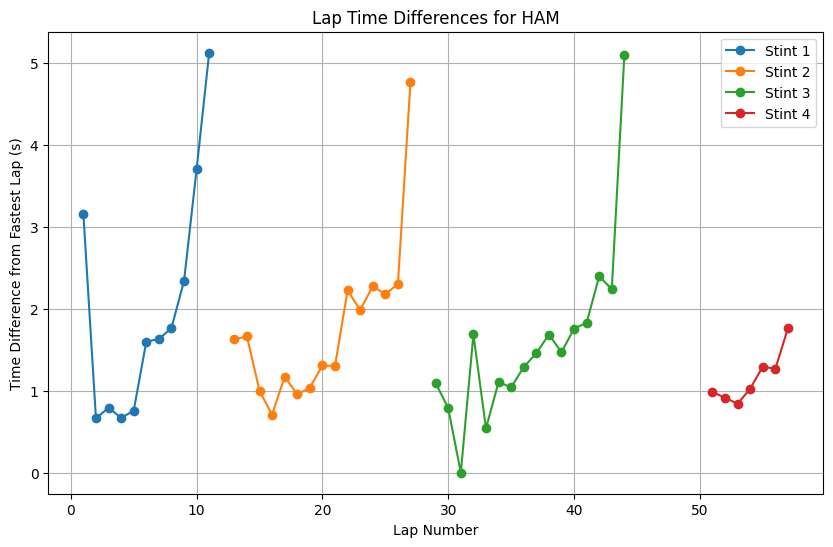

In [4]:
import matplotlib.pyplot as plt

def analyze_driver_fastest_lap_and_stints(df, driver_short):
    """
    Analyze the difference between a driver's fastest lap and their other laps,
    and plot each stint in a different color.
    
    Args:
        df (pd.DataFrame): The DataFrame containing race data.
        driver_short (str): Short name of the driver (e.g., 'HAM').
    
    Returns:
        pd.DataFrame: A DataFrame with differences from the fastest lap.
    """
    # Filter the DataFrame for the specified driver
    driver_df = df[df['driver_short'] == driver_short]
    
    # Ensure there are valid laps for the driver
    if driver_df.empty:
        print(f"No data available for driver {driver_short}.")
        return None
    
    # Find the fastest lap time
    fastest_lap_time = driver_df['fuel_corrected_lap_time'].min()
    
    # Filter laps within 7% of the fastest lap
    driver_df = driver_df[driver_df['fuel_corrected_lap_time'] <= 1.07 * fastest_lap_time]
    
    # Calculate the difference from the fastest lap for each lap
    driver_df['time_diff'] = driver_df['fuel_corrected_lap_time'] - fastest_lap_time
    
    # Plot each stint with a different color
    plt.figure(figsize=(10, 6))
    stints = driver_df['stint'].unique()
    colors = plt.cm.tab10.colors  # Use a color map for distinct colors
    
    for i, stint in enumerate(stints):
        stint_data = driver_df[driver_df['stint'] == stint]
        plt.plot(
            stint_data['lap_num'],
            stint_data['time_diff'],
            marker='o',
            linestyle='-',
            label=f"Stint {stint}",
            color=colors[i % len(colors)]  # Cycle through colors if more than 10 stints
        )
    
    plt.title(f"Lap Time Differences for {driver_short}")
    plt.xlabel("Lap Number")
    plt.ylabel("Time Difference from Fastest Lap (s)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return driver_df[['lap_num', 'lap_time', 'time_diff', 'stint']]


testDF = adjusted_race_df[(adjusted_race_df["year"] == 2022) & (adjusted_race_df["round"] == 1)]

# Analyze and plot
driver_data = analyze_driver_fastest_lap_and_stints(testDF, "HAM")


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_driver_fastest_lap_and_stints(df, driver_short):
    """
    Analyze the difference between a driver's fastest lap and their other laps,
    plot each stint in a different color with tyre type labels, and perform
    polynomial regression to model trends for each stint.
    
    Args:
        df (pd.DataFrame): The DataFrame containing race data.
        driver_short (str): Short name of the driver (e.g., 'HAM').
    
    Returns:
        pd.DataFrame: A DataFrame with differences from the fastest lap.
    """
    # Filter the DataFrame for the specified driver
    driver_df = df[df['driver_short'] == driver_short]
    
    # Ensure there are valid laps for the driver
    if driver_df.empty:
        print(f"No data available for driver {driver_short}.")
        return None
    
    # Find the fastest lap time
    fastest_lap_time = driver_df['fuel_corrected_lap_time'].min()
    
    # Filter laps within 7% of the fastest lap
    driver_df = driver_df[driver_df['fuel_corrected_lap_time'] <= 1.07 * fastest_lap_time]
    
    # Calculate the difference from the fastest lap for each lap
    driver_df['time_diff'] = driver_df['fuel_corrected_lap_time'] - fastest_lap_time
    
    # Plot each stint with a different color
    plt.figure(figsize=(12, 8))
    stints = driver_df['stint'].unique()
    colors = plt.cm.tab10.colors  # Use a color map for distinct colors
    
    for i, stint in enumerate(stints):
        stint_data = driver_df[driver_df['stint'] == stint]
        tyre_type = stint_data['tyre'].iloc[0]  # Get the tyre type for the stint
        
        # Plot the actual lap data
        plt.plot(
            stint_data['lap_num'],
            stint_data['time_diff'],
            marker='o',
            linestyle='-',
            label=f"Stint {stint} - {tyre_type}",
            color=colors[i % len(colors)]  # Cycle through colors if more than 10 stints
        )
        
        # Polynomial regression
        x = stint_data['lap_num']
        y = stint_data['time_diff']
        if len(x) > 2:  # Only fit if there are enough points
            poly_coeffs = np.polyfit(x, y, 2)  # 2nd degree polynomial
            poly_fit = np.poly1d(poly_coeffs)
            plt.plot(
                x,
                poly_fit(x),
                linestyle='--',
                color=colors[i % len(colors)],
                alpha=0.7,
                label=f"Stint {stint} Fit"
            )
    
    plt.title(f"Lap Time Differences for {driver_short}")
    plt.xlabel("Lap Number")
    plt.ylabel("Time Difference from Fastest Lap (s)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return driver_df[['lap_num', 'lap_time', 'time_diff', 'stint', 'tyre']]


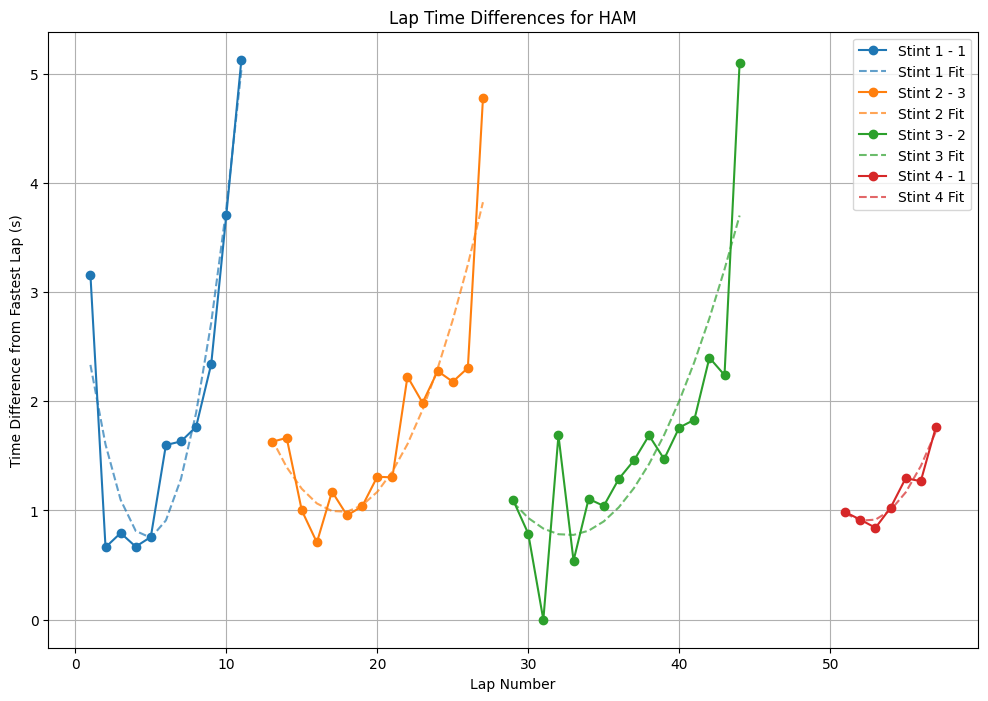

        lap_num  lap_time  time_diff  stint  tyre
144453        1   101.555   3.158158      1     1
144454        2    99.002   0.663053      1     1
144455        3    99.075   0.793947      1     1
144456        4    98.892   0.668842      1     1
144457        5    98.923   0.757737      1     1


In [6]:
testDF = adjusted_race_df[(adjusted_race_df["year"] == 2022) & (adjusted_race_df["round"] == 1)]

# Analyze and plot
driver_data = analyze_driver_fastest_lap_and_stints(testDF, "HAM")
print(driver_data.head())

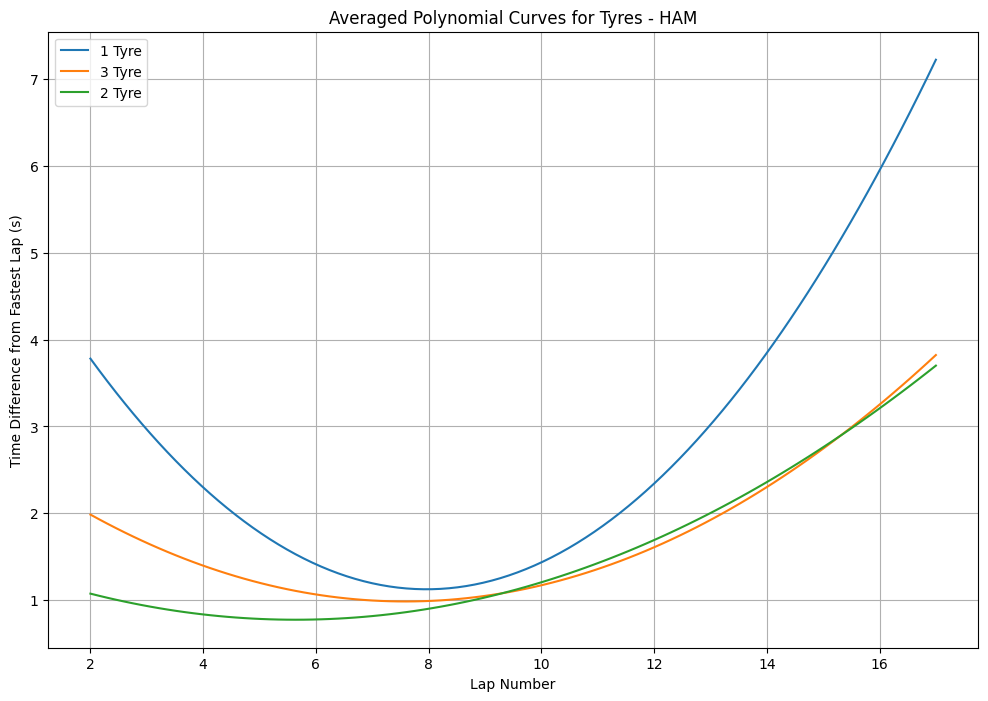

{np.int64(1): array([ 0.074706  , -1.18988366,  5.86221192]), np.int64(3): array([ 0.03204581, -0.48634655,  2.82918677]), np.int64(2): array([ 0.02268137, -0.25584546,  1.49497988])}


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def analyze_tyres_with_polynomial_curves(df, driver_short):
    """
    Analyze and plot polynomial curves for each tyre type by averaging lap times
    across stints that use the same tyre type after performing polynomial regression 
    for each stint.
    
    Args:
        df (pd.DataFrame): The DataFrame containing race data.
        driver_short (str): Short name of the driver (e.g., 'HAM').
    
    Returns:
        pd.DataFrame: A DataFrame with averaged data for each tyre type.
    """
    # Filter the DataFrame for the specified driver
    driver_df = df[df['driver_short'] == driver_short]
    
    # Ensure there are valid laps for the driver
    if driver_df.empty:
        print(f"No data available for driver {driver_short}.")
        return None
    
    # Find the fastest lap time
    fastest_lap_time = driver_df['fuel_corrected_lap_time'].min()
    
    # Filter laps within 7% of the fastest lap
    driver_df = driver_df[driver_df['fuel_corrected_lap_time'] <= 1.07 * fastest_lap_time]
    
    # Calculate the difference from the fastest lap for each lap
    driver_df['time_diff'] = driver_df['fuel_corrected_lap_time'] - fastest_lap_time
    
    # Initialize a dictionary to store the polynomial regressions for each tyre type
    tyre_regressions = {}
    
    # Loop through each tyre type
    for tyre in driver_df['tyre'].unique():
        tyre_data = driver_df[driver_df['tyre'] == tyre]
        # Initialize lists to store polynomial coefficients for each stint
        poly_coeffs_list = []
        
        # Loop through each stint for the given tyre type and fit a polynomial
        for stint in tyre_data['stint'].unique():
            stint_data = tyre_data[tyre_data['stint'] == stint]
            x = stint_data['tyre_laps']
            y = stint_data['time_diff']
            
            # Perform polynomial regression (2nd degree)
            if len(x) > 2:  # Only fit if there are enough points
                poly_coeffs = np.polyfit(x, y, 2)
                poly_coeffs_list.append(poly_coeffs)
        
        # If we have multiple polynomials, average the coefficients
        if poly_coeffs_list:
            avg_poly_coeffs = np.mean(poly_coeffs_list, axis=0)
            tyre_regressions[tyre] = avg_poly_coeffs

    # Plot the averaged polynomial curves for each tyre type
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10.colors  # Use a color map for distinct colors
    for i, (tyre, avg_poly_coeffs) in enumerate(tyre_regressions.items()):
        # Create a polynomial function from the averaged coefficients
        poly_fit = np.poly1d(avg_poly_coeffs)
        
        # Define a range of lap numbers for smooth plotting
        x_vals = np.linspace(driver_df['tyre_laps'].min(), driver_df['tyre_laps'].max(), 100)
        y_vals = poly_fit(x_vals)
        
        # Plot the averaged polynomial curve
        plt.plot(x_vals, y_vals, linestyle='-', color=colors[i % len(colors)], label=f"{tyre} Tyre")

    plt.title(f"Averaged Polynomial Curves for Tyres - {driver_short}")
    plt.xlabel("Lap Number")
    plt.ylabel("Time Difference from Fastest Lap (s)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return tyre_regressions

# Example usage
testDF = adjusted_race_df[(adjusted_race_df["year"] == 2022) & (adjusted_race_df["round"] == 1)]

# Analyze and plot
tyre_regressions = analyze_tyres_with_polynomial_curves(testDF, "HAM")
print(tyre_regressions)


        year  round
238345  2023     22
236243  2023     21
234454  2023     20
231741  2023     19
230212  2023     18
228521  2023     17
226701  2023     16
224510  2023     15
222291  2023     14
219484  2023     13


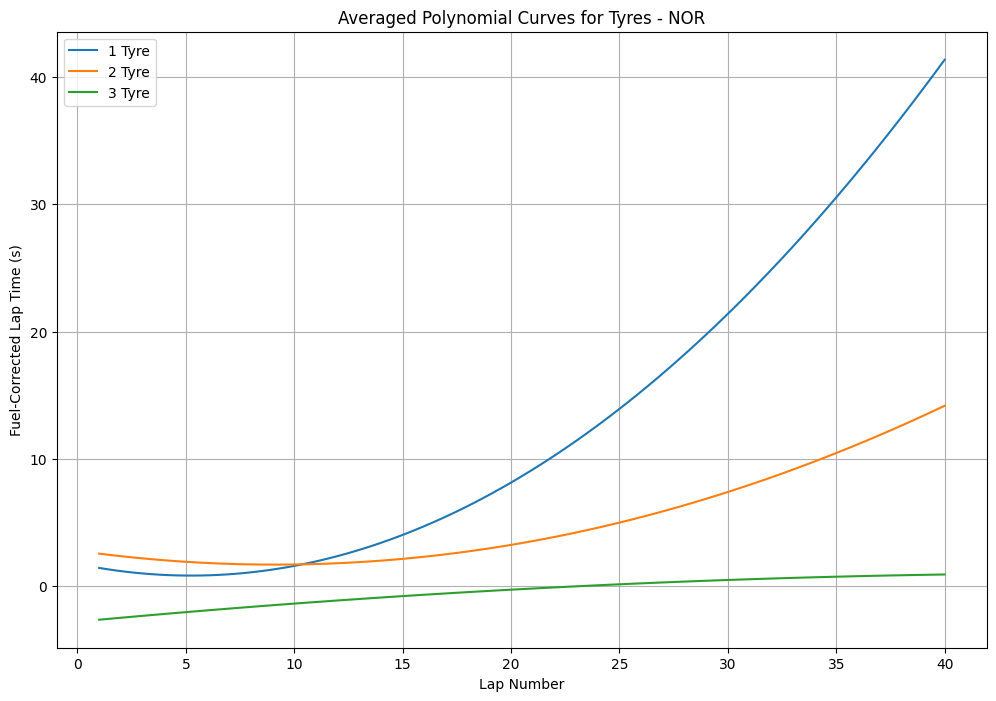

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def correct_fuel_effect(df, year, race_round, max_fuel_kg=110, fuel_effect_per_kg=0.03):
    # Adjust lap times in a race for the effect of fuel weight
    race_df = df[(df['year'] == year) & (df['round'] == race_round) & (df['session_type'] == "Race")].copy()
    max_laps = race_df['lap_num'].max()
    race_df['fuel_weight'] = max_fuel_kg - (race_df['lap_num'] - 1) * (max_fuel_kg / max_laps)
    race_df['fuel_correction'] = race_df['fuel_weight'] * fuel_effect_per_kg
    race_df['fuel_corrected_lap_time'] = race_df['lap_time'] - race_df['fuel_correction']
    return race_df

def assign_stint_numbers(df):
    # Assign stint numbers to laps based on pit stops for each driver
    df['stint'] = np.nan
    for driver in df['driver_short'].unique():
        driver_data = df[df['driver_short'] == driver]
        stint_number = 1
        for i in driver_data.index:
            if driver_data.loc[i, 'pit'] and i != driver_data.index[0]:
                stint_number += 1
            df.loc[i, 'stint'] = stint_number
    df['stint'] = df['stint'].astype(int)
    return df

def get_last_10_races_from_round(df, year, round_):
    # Get the last 10 unique races starting from a given year and round
    df_unique = df.drop_duplicates(subset=['year', 'round'])
    filtered_df = df_unique[
        (df_unique['year'] < year) | 
        ((df_unique['year'] == year) & (df_unique['round'] <= round_))
    ]
    df_sorted = filtered_df.sort_values(by=['year', 'round'], ascending=[False, False])
    last_10_races = df_sorted[['year', 'round']].head(10)
    return last_10_races

def analyze_and_average_polynomials(df, driver, current_year, current_round):
    # Get the last 10 races starting from the current race
    last_10_races = get_last_10_races_from_round(df, current_year, current_round)
    print(last_10_races)
    
    # Store polynomial coefficients for each tyre type across races
    tyre_poly_coeffs = {tyre: [] for tyre in df['tyre'].unique()}
    
    # Loop through each race in the last 10 races
    for _, race in last_10_races.iterrows():
        year = race['year']
        round_ = race['round']
        
        # Filter the DataFrame for the specific race and driver
        race_df = df[(df['year'] == year) & (df['round'] == round_) & (df['driver_short'] == driver)].copy()
        
        # Correct for fuel effect
        race_df = correct_fuel_effect(race_df, year, round_)
        
        # Normalize lap times based on the fastest lap and filter out outliers
        fastest_lap_time = race_df['fuel_corrected_lap_time'].min()
        race_df = race_df[race_df['fuel_corrected_lap_time'] <= 1.07 * fastest_lap_time]  # Filter out lap times more than 7% slower
        
        # Calculate the difference from the fastest lap for each lap
        race_df['time_diff'] = race_df['fuel_corrected_lap_time'] - fastest_lap_time
        
        # Assign stint numbers
        race_df = assign_stint_numbers(race_df)
        
        # Loop over each tyre type and perform polynomial regression for each stint
        for tyre in race_df['tyre'].unique():
            tyre_data = race_df[race_df['tyre'] == tyre]
            
            # Loop through each stint for the given tyre type
            for stint in tyre_data['stint'].unique():
                stint_data = tyre_data[tyre_data['stint'] == stint]
                x = stint_data['lap_num']
                y = stint_data['time_diff']
                
                # Polynomial regression (2nd degree)
                if len(x) > 2:
                    poly_coeffs = np.polyfit(x, y, 2)
                    tyre_poly_coeffs[tyre].append(poly_coeffs)
    
    # Average the polynomial coefficients for each tyre type across all races
    averaged_poly_coeffs = {}
    for tyre, poly_coeffs_list in tyre_poly_coeffs.items():
        if poly_coeffs_list:
            avg_poly_coeffs = np.mean(poly_coeffs_list, axis=0)
            averaged_poly_coeffs[tyre] = avg_poly_coeffs
    
    # Plot the averaged polynomial curves for each tyre type
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10.colors  # Use a color map for distinct colors
    
    for i, (tyre, coeffs) in enumerate(averaged_poly_coeffs.items()):
        # Create a polynomial function from the averaged coefficients
        poly_fit = np.poly1d(coeffs)
        
        # Create an x-axis range for plotting
        x_range = np.linspace(1, 40, 100)  # Adjust lap range as needed
        y_fit = poly_fit(x_range)
        
        plt.plot(x_range, y_fit, linestyle='-', color=colors[i % len(colors)], label=f"{tyre} Tyre")
    
    plt.title(f"Averaged Polynomial Curves for Tyres - {driver}")
    plt.xlabel("Lap Number")
    plt.ylabel("Fuel-Corrected Lap Time (s)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
df = create_dataframe()

# Analyze and average polynomials for the last 10 races
analyze_and_average_polynomials(df, driver='NOR', current_year=2023, current_round=22)
